In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')


#reading the csv
file_name = "deaths-by-cause.csv"
file_path = os.path.join(os.path.expanduser("~"), file_name)
df_raw = pd.read_csv(file_path)

#filtering for only targeted countries, and renaming column names. Also dropping execution column since it is consisted of mostly na values.
targeted_countries = ['Japan', 'Russia', 'United States']

df = df_raw.drop(columns=['Number of executions (Amnesty International)'])
clean_columns = [
    'Country', 'Code', 'Year', 'Meningitis', 'Neoplasms', 'Fire, heat, and hot substances',
    'Malaria', 'Drowning', 'Interpersonal violence', 'HIV/AIDS', 'Drug use disorders',
    'Tuberculosis', 'Road injuries', 'Maternal disorders', 'Lower respiratory infections',
    'Neonatal disorders', 'Alcohol use disorders', 'Exposure to forces of nature',
    'Diarrheal diseases', 'Environmental heat and cold exposure',
    'Nutritional deficiencies', 'Self-harm', 'Conflict and terrorism', 'Diabetes mellitus',
    'Poisonings', 'Protein-energy malnutrition', 'Terrorism',
    'Cardiovascular diseases', 'Chronic kidney disease', 'Chronic respiratory diseases',
    'Cirrhosis and other chronic liver diseases', 'Digestive diseases', 'Acute hepatitis',
    'Alzheimer’s disease and other dementias', 'Parkinson’s disease'
]
df.columns = clean_columns

df = df.loc[df['Country'].isin(targeted_countries)]

#dropping columns with full of na values
df = df.dropna(how='all', axis= 1)

In [2]:
#adding total deaths column
causes =  df.columns[3:]
df['Total deaths'] = df[causes].sum(axis=1)

#setting df2 and grouped df2 for global comparisons
df2 = df_raw.drop(columns= 'Number of executions (Amnesty International)')
df2.columns = clean_columns
df2['Total Deaths'] = df2[causes].sum(axis=1)
df2_grouped = df2.groupby('Country')[df2.columns[3:]].sum()

In [3]:
#comparing three regions 
europe = ['Iceland', 'Norway', 'Switzerland', 'Sweden', 'United Kingdom', 
          'Portugal', 'Germany', 'Netherlands', 'Spain', 'France', 'Italy',
          'Belgium', 'Finland', 'Ireland', 'Greece', 'Austria', 'Denmark',
          "Russia", "Ukraine", "Belarus", "Estonia", "Latvia", 
          "Lithuania", "Poland", "Czech Republic", "Slovakia", "Hungary",
          "Romania", "Bulgaria", "Moldova", "Slovenia"]
europe_10 = df2[df2['Country'].isin(europe)].groupby('Country')[df2.columns[3:]].mean().mean().round(2).nlargest(21)

america = [
    'Argentina', 'Bahamas', 'Barbados', 'Belize', 'Bolivia', 'Brazil', 
    'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 
    'Dominican Republic', 'Ecuador', 'El Salvador', 'Grenada', 'Guatemala', 
    'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 
    'Panama', 'Paraguay', 'Peru', 'Saint Kitts and Nevis', 'Saint Lucia', 
    'Saint Vincent and the Grenadines', 'Suriname', 'Trinidad and Tobago', 
    'United States', 'Uruguay', 'Venezuela'
]

america_10 = df2[df2['Country'].isin(america)].groupby('Country')[df2.columns[3:]].mean().mean().round(2).nlargest(21)

asia_countries = ['Japan', 'South Korea', 'China', 'Taiwan', 'Philippines', 'Thailand',
        'Vietnam', 'Malaysia', 'Singapore', 'Indonesia', 'Myanmar', 'Cambodia',
        'Laos', 'Bangladesh', 'Nepal', 'Sri Lanka']

asia_10 = df2[df2['Country'].isin(asia_countries)].groupby('Country')[df2.columns[3:]].mean().mean().round(2).nlargest(21)

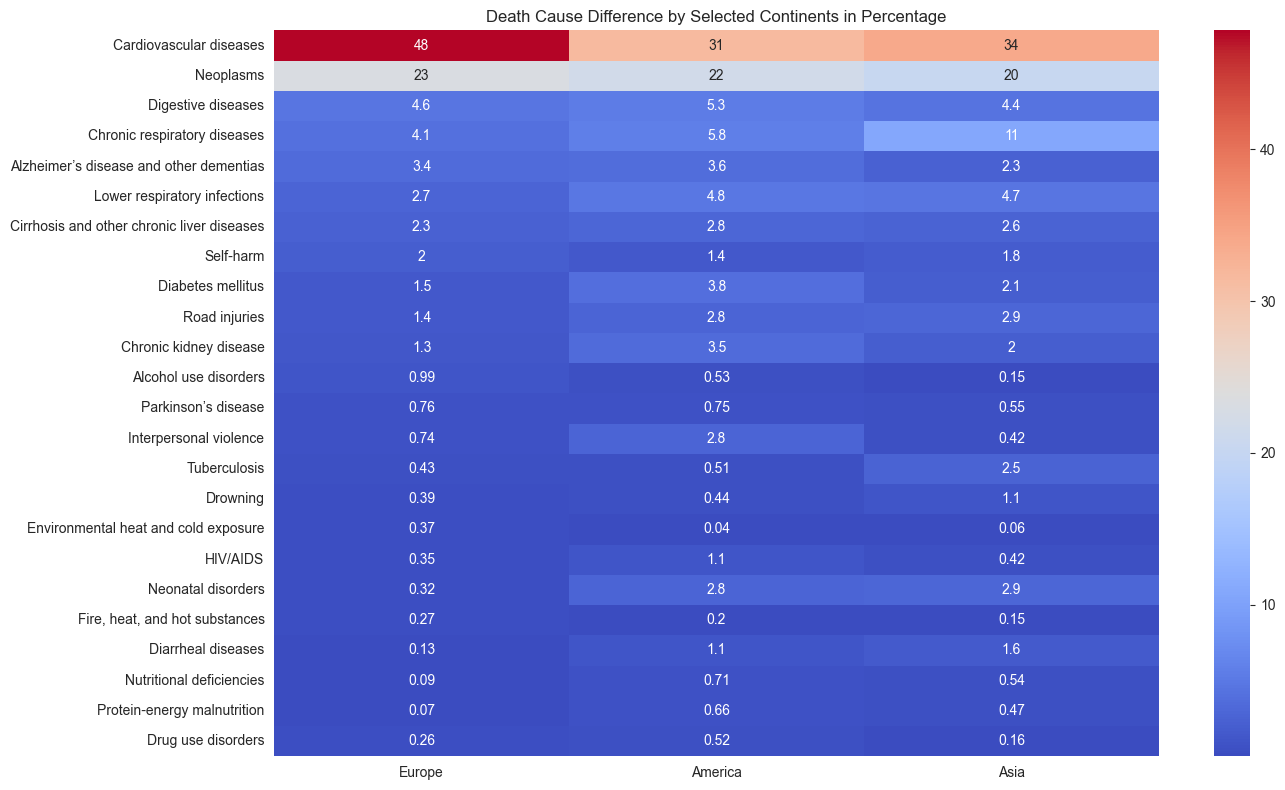

In [4]:
world_10 = pd.concat([europe_10, america_10, asia_10], axis=1)
world_10.columns =  ['Europe', 'America', 'Asia']

world_10.loc['Cardiovascular diseases': , 'Europe'] = df2[df2['Country'].isin(europe)][world_10.index[1:]].mean()
world_10.loc['Cardiovascular diseases': , 'America'] = df2[df2['Country'].isin(america)][world_10.index[1:]].mean()
world_10.loc['Cardiovascular diseases': , 'Asia'] = df2[df2['Country'].isin(asia_countries)][world_10.index[1:]].mean()

world_percentage = (world_10.div(world_10.loc['Total Deaths'], axis=1) * 100).round(2)
world_percentage = world_percentage.drop(['Total Deaths'], axis=0)

plt.figure(figsize=(14, 8))
sns.heatmap(world_percentage, annot=True, cmap='coolwarm', cbar=True)
plt.title('Death Cause Difference by Selected Continents in Percentage')
plt.tight_layout()
plt.draw()
plt.savefig('graphs/world_heatmap.png')

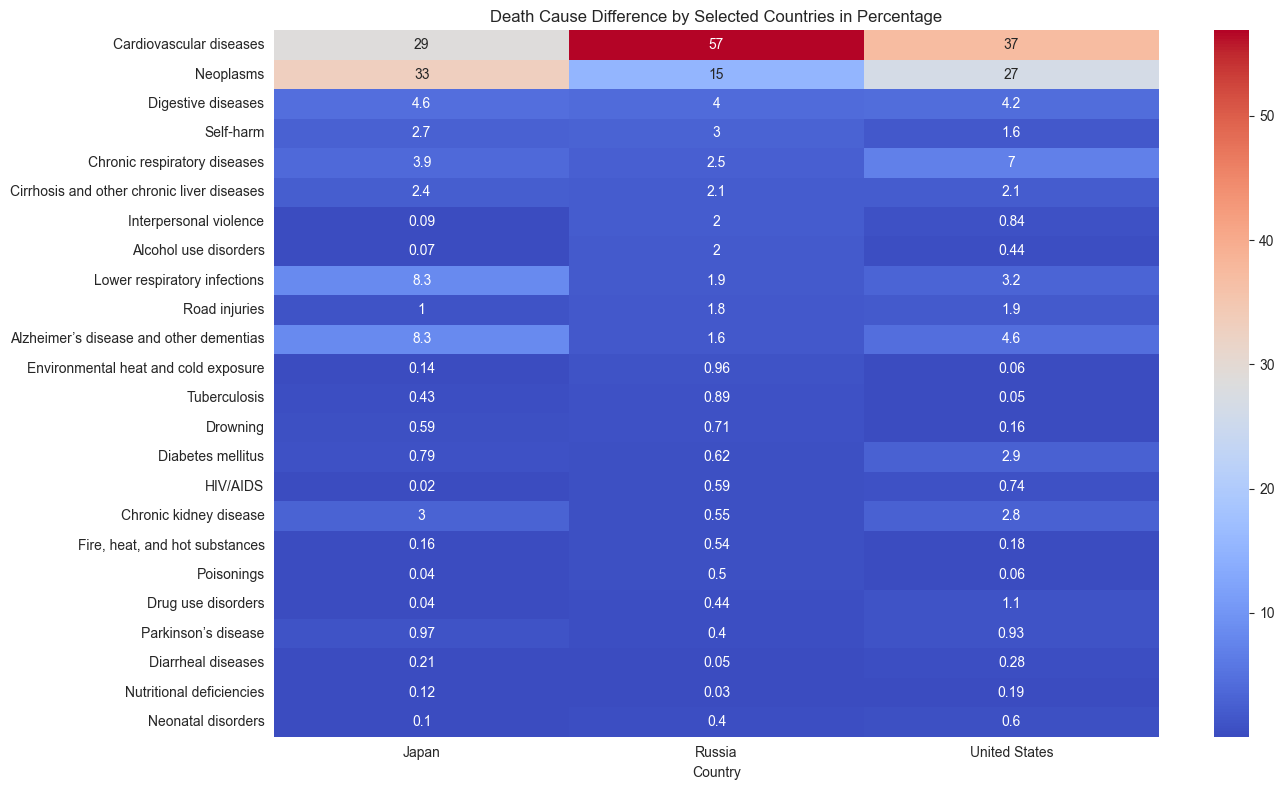

In [5]:
df2_percentage = (df2_grouped[df2_grouped.columns].div(df2_grouped['Total Deaths'], axis=0) * 100)
rujaus_percentage = df2_percentage[df2_percentage.index.isin(['Russia', 'Japan', 'United States'])].round(2)
rujaus = rujaus_percentage.div(rujaus_percentage['Total Deaths'], axis=0) * 100
rujaus = rujaus.drop(['Total Deaths'], axis= 1)
rujaus = rujaus.apply(lambda x: x.nlargest(20), axis=1)
rujaus = rujaus.transpose().sort_values(by=['Russia', 'Japan', 'United States'], ascending=False)

rujaus.loc['Cardiovascular diseases': , 'Japan'] = rujaus_percentage.loc['Japan', rujaus.index]
rujaus.loc['Cardiovascular diseases': , 'Russia'] = rujaus_percentage.loc['Russia', rujaus.index]
rujaus.loc['Cardiovascular diseases': , 'United States'] = rujaus_percentage.loc['United States', rujaus.index]

plt.figure(figsize=(14, 8))
sns.heatmap(rujaus, annot=True, cmap='coolwarm', cbar=True)
plt.title('Death Cause Difference by Selected Countries in Percentage')
plt.tight_layout()
plt.draw()
plt.savefig('graphs/rujaus_heatmap.png')

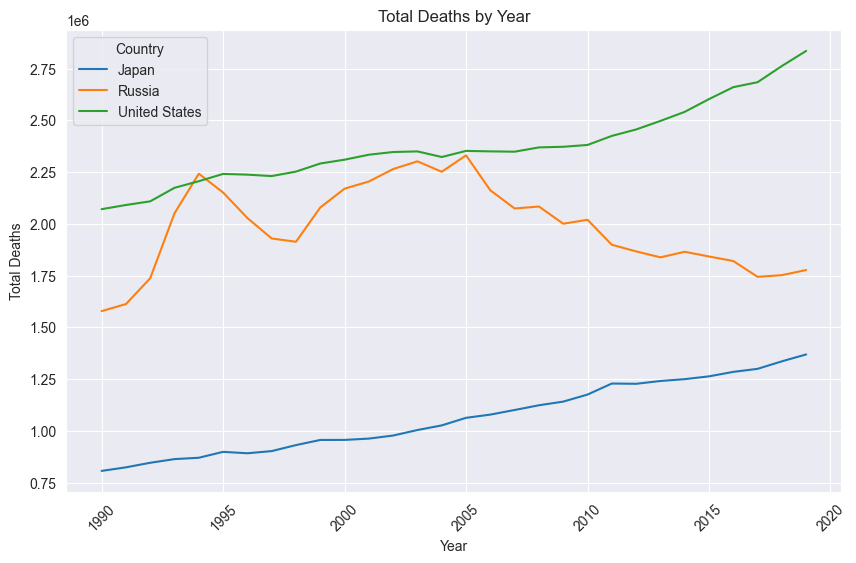

In [6]:
#plotting total deaths by year for each country

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Year', y='Total deaths', hue='Country', data=df, ax=ax)
ax.set_title('Total Deaths by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.draw()
plt.savefig('graphs/total_deaths_by_year.png')

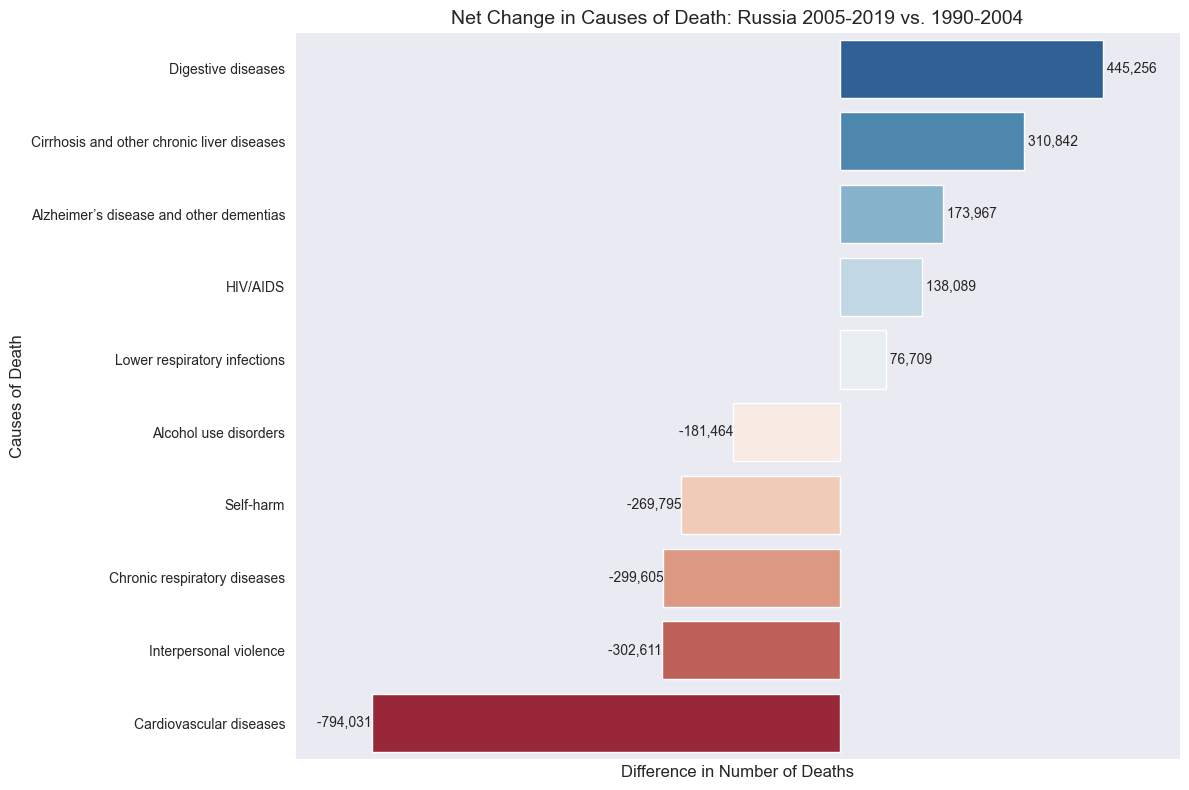

In [7]:
#comparing Russia before and after 2005
before_2005_russia = df[(df['Country'] == 'Russia') & (df['Year'] < 2005)].groupby('Country')[causes].sum()
after_2005_russia =  df[(df['Country'] == 'Russia') & (df['Year'] >= 2005)].groupby('Country')[causes].sum()


russia_diff =  pd.DataFrame(after_2005_russia - before_2005_russia)

#printing the biggest differences before and after 2005
russia_5_diff_largest = russia_diff.loc['Russia'].nlargest(5)
russia_5_diff_smallest = russia_diff.loc['Russia'].nsmallest(5)
russia_5_diff_concat = pd.concat([russia_5_diff_largest, russia_5_diff_smallest], axis=0)
russia_5_diff_concat = russia_5_diff_concat.sort_values(ascending= False)

# Set up the plot
fig1, ax = plt.subplots(figsize=(12, 8))
sns.set_style("darkgrid")

# Create the bar plot
sns.barplot(x=russia_5_diff_concat.values, y=russia_5_diff_concat.index, 
                 hue= russia_5_diff_concat.index, palette= 'RdBu_r', orient='h',ax=ax, legend= False)

# Add value labels
for i, v in enumerate(russia_5_diff_concat.values):
    if v >= 0:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='left')
    else:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='right')


# Customize the plot
ax.set_title('Net Change in Causes of Death: Russia 2005-2019 vs. 1990-2004', fontsize=14)
ax.set_xlabel('Difference in Number of Deaths', fontsize=12)
ax.set_ylabel('Causes of Death', fontsize=12)
ax.set_xticks([])

# Set x-axis limits to make room for annotations
x_min, x_max = plt.xlim()
plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

plt.tight_layout()
plt.draw()
plt.savefig('graphs/russia differences.png')


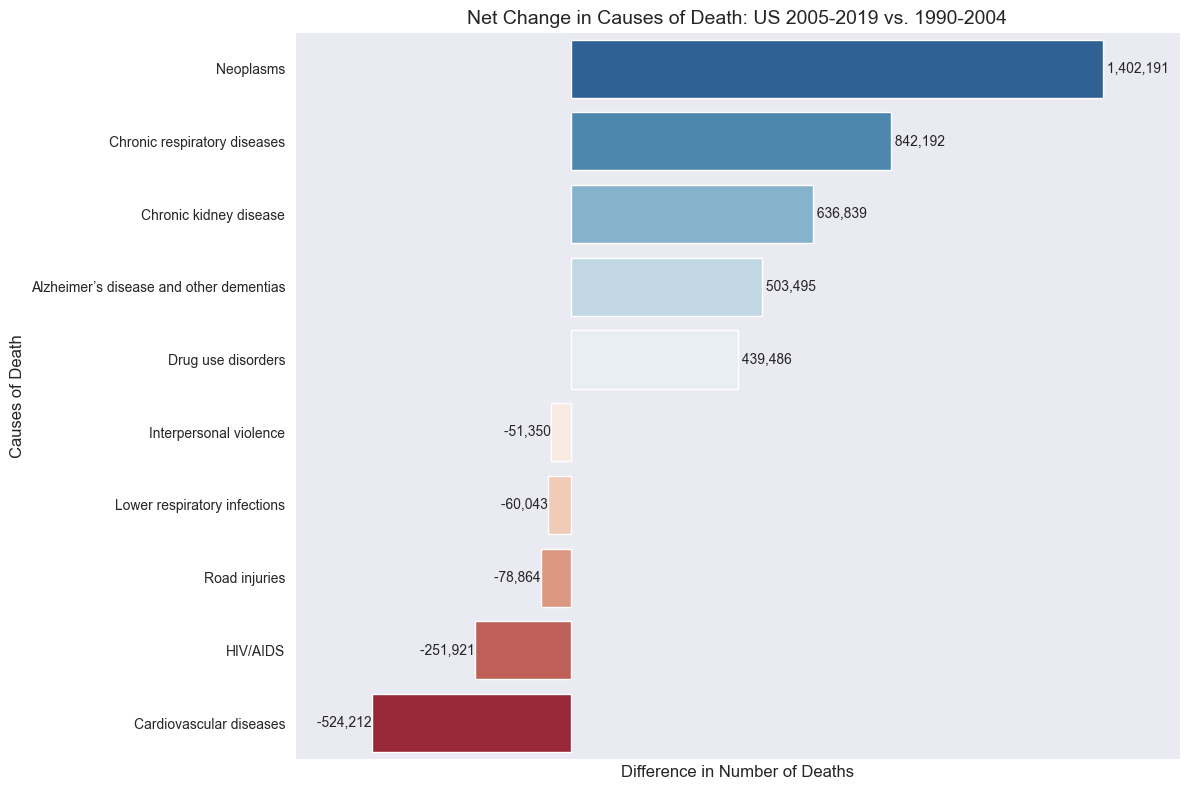

In [8]:
#comparing United States in 1990 and 2019
before_2005_usa = df[(df['Country'] == 'United States') & (df['Year'] < 2005)].groupby('Country')[causes].sum()
after_2005_usa =  df[(df['Country'] == 'United States') & (df['Year'] >= 2005)].groupby('Country')[causes].sum()

usa_diff =  pd.DataFrame(after_2005_usa - before_2005_usa)

#printing the biggest differences in 1990 and 2019
usa_5_diff_largest = usa_diff.loc['United States'].nlargest(5)
usa_5_diff_smallest = usa_diff.loc['United States'].nsmallest(5)
usa_5_diff_concat = pd.concat([usa_5_diff_largest, usa_5_diff_smallest], axis=0)
usa_5_diff_concat = usa_5_diff_concat.sort_values(ascending= False)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("darkgrid")

# Create the bar plot
sns.barplot(x=usa_5_diff_concat.values, y=usa_5_diff_concat.index, 
                 hue= usa_5_diff_concat.index, palette= 'RdBu_r', orient='h',ax=ax, legend= False)

# Add value labels
for i, v in enumerate(usa_5_diff_concat.values):
    if v >= 0:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='left')
    else:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='right')

# Customize the plot
ax.set_title('Net Change in Causes of Death: US 2005-2019 vs. 1990-2004', fontsize=14)
ax.set_xlabel('Difference in Number of Deaths', fontsize=12)
ax.set_ylabel('Causes of Death', fontsize=12)
ax.set_xticks([])

# Set x-axis limits to make room for annotations
x_min, x_max = plt.xlim()
plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

plt.tight_layout()
plt.draw()
plt.savefig('graphs/usa differences.png')



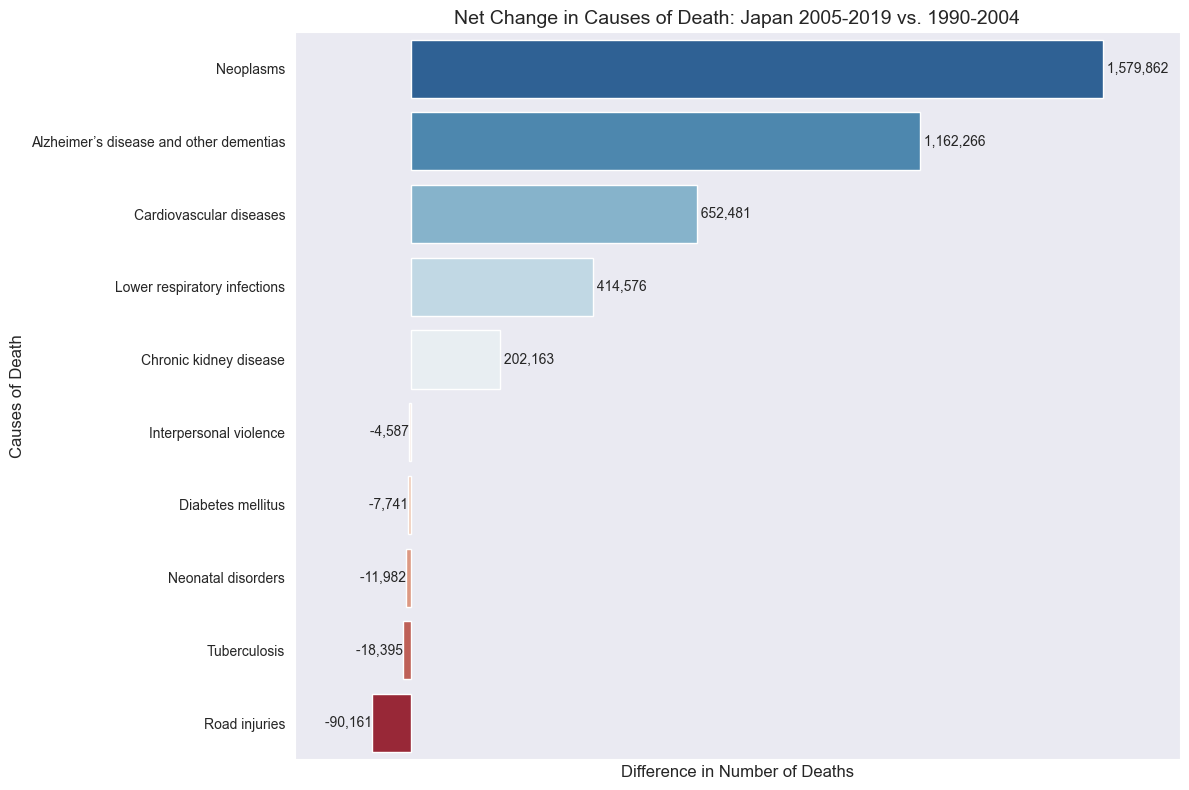

In [9]:
#comparing Japan in 1990 and 2019
before_2005_japan = df[(df['Country'] == 'Japan') & (df['Year'] < 2005)].groupby('Country')[causes].sum()
after_2005_japan =  df[(df['Country'] == 'Japan') & (df['Year'] >= 2005)].groupby('Country')[causes].sum()

japan_diff =  pd.DataFrame(after_2005_japan - before_2005_japan)

#printing the biggest differences in 1990 and 2019
japan_5_diff_largest = japan_diff.loc['Japan'].nlargest(5)
japan_5_diff_smallest = japan_diff.loc['Japan'].nsmallest(5)
japan_5_diff_concat = pd.concat([japan_5_diff_largest, japan_5_diff_smallest], axis=0)
japan_5_diff_concat = japan_5_diff_concat.sort_values(ascending= False)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("darkgrid")

# Create the bar plot
sns.barplot(x=japan_5_diff_concat.values, y=japan_5_diff_concat.index, 
                 hue= japan_5_diff_concat.index, palette= 'RdBu_r', orient='h',ax=ax, legend= False)

# Add value labels
for i, v in enumerate(japan_5_diff_concat.values):
    if v >= 0:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='left')
    else:
        ax.text(v, i, f' {v:,.0f}', va='center', ha='right')


# Customize the plot
ax.set_title('Net Change in Causes of Death: Japan 2005-2019 vs. 1990-2004', fontsize=14)
ax.set_xlabel('Difference in Number of Deaths', fontsize=12)
ax.set_ylabel('Causes of Death', fontsize=12)
ax.set_xticks([])

# Set x-axis limits to make room for annotations
x_min, x_max = plt.xlim()
plt.xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

plt.tight_layout()
plt.draw()
plt.savefig('graphs/japan differences.png')

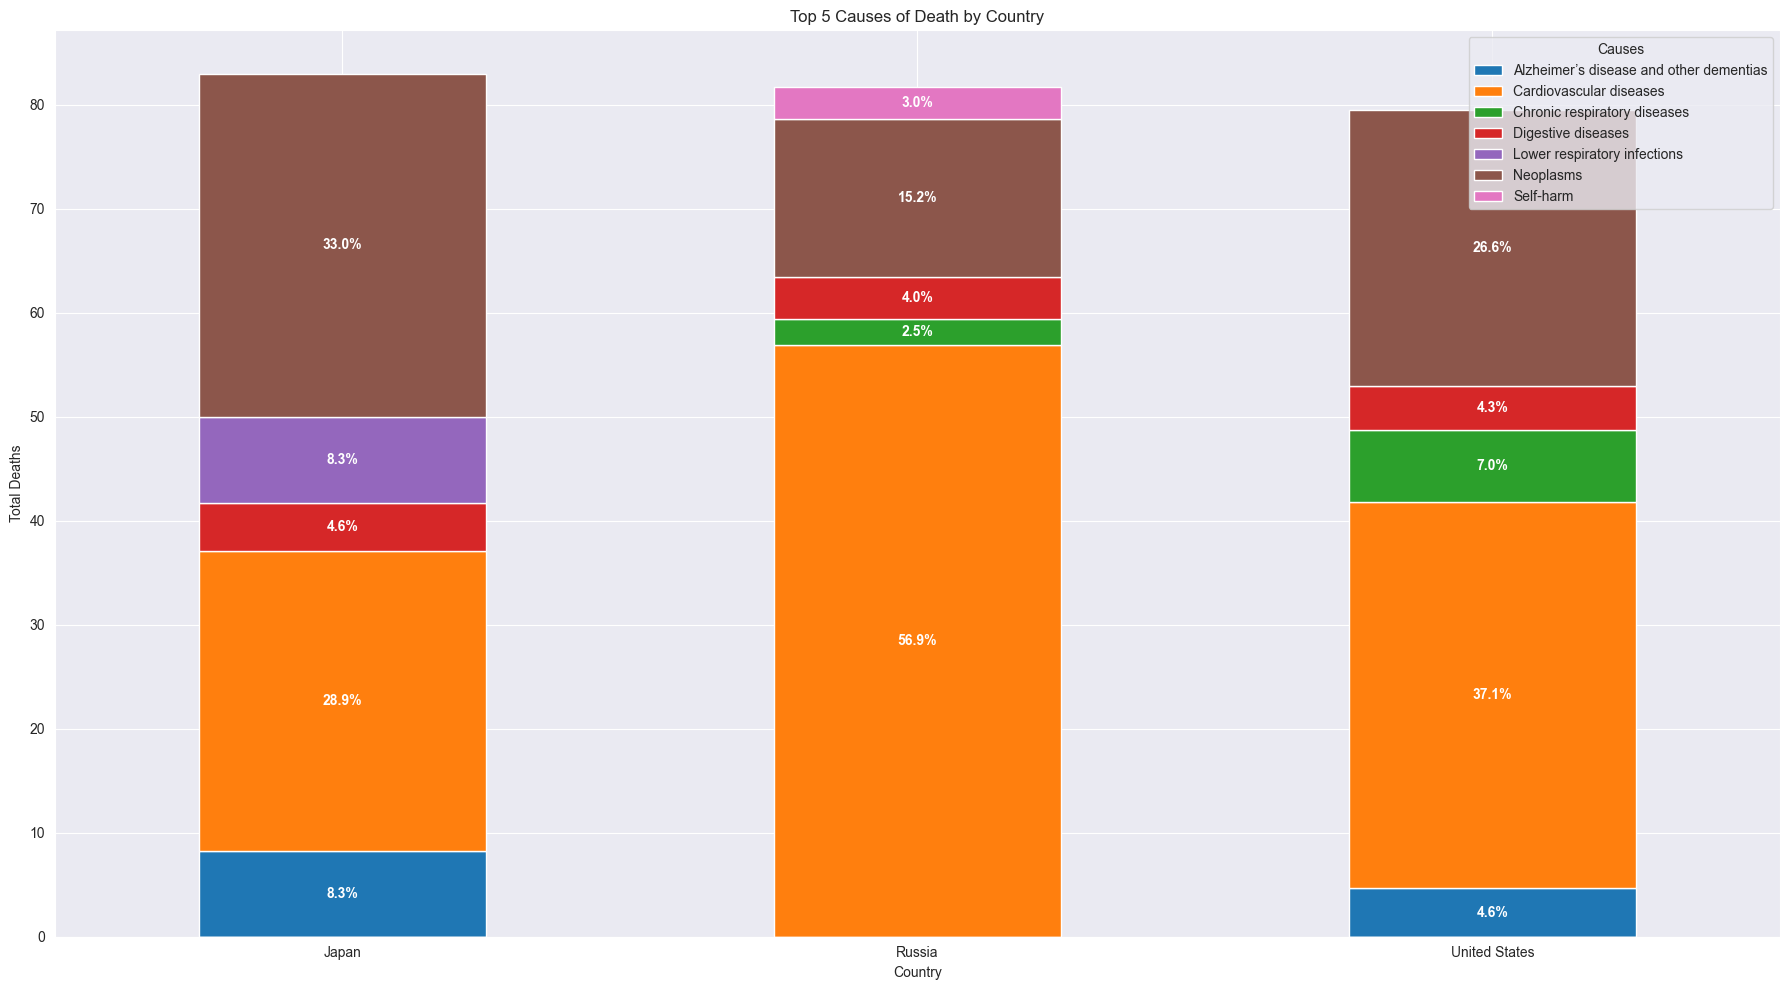

In [10]:
#plotting top 5 causes of death by country
df_grouped = df.drop(columns= ['Total deaths']).groupby('Country')[causes].sum()
df_grouped['Total deaths'] = df_grouped.sum(axis=1)
df_largest = df_grouped.apply(lambda x: x.nlargest(6), axis=1)
df_largest.fillna(0, inplace= True)
df_largest_percentage =  (df_largest.div(df_largest['Total deaths'], axis=0)) * 100
df_largest_percentage.drop(columns='Total deaths', inplace= True)

fig, ax = plt.subplots(figsize=(14, 8))
df_largest_percentage.plot(kind='bar', stacked=True, figsize=(18,10), title='Top 5 Causes of Death by Country', xlabel='Country', ylabel='Total Deaths', rot=0, ax=ax)

for c in ax.containers:
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 0.1 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, color='white', weight='bold')

plt.tight_layout()
plt.legend(title='Causes')
plt.draw()
plt.savefig('graphs/top_5_causes_of_death_by_country.png')

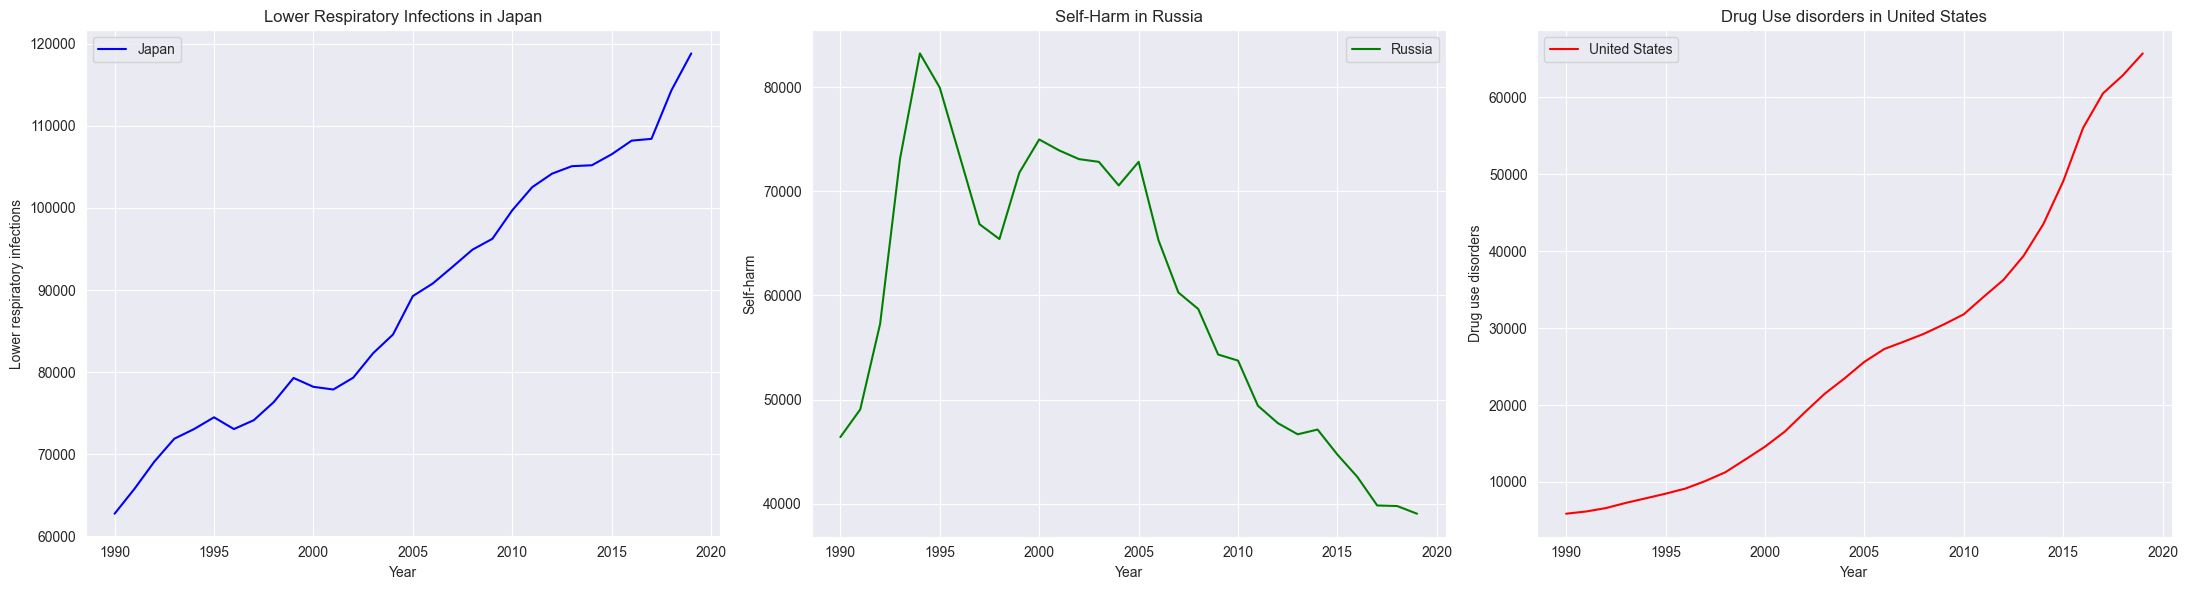

In [11]:
#inspecting the distinctive cause for each country
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(22, 6))

distinctive_japan = df[df['Country'] == 'Japan'][['Country','Year', 'Lower respiratory infections']]
sns.lineplot(data= distinctive_japan, x='Year', y='Lower respiratory infections',  label='Japan', color='blue', ax=ax1)
ax1.set_title('Lower Respiratory Infections in Japan')

distinctive_russia = df[df['Country'] == 'Russia'][['Country','Year', 'Self-harm']]
sns.lineplot(data= distinctive_russia, x='Year', y='Self-harm', label='Russia', color='green', ax=ax2)
ax2.set_title('Self-Harm in Russia')

distinctive_usa = df[df['Country'] == 'United States'][['Country','Year', 'Drug use disorders']]
sns.lineplot(data= distinctive_usa, x='Year', y='Drug use disorders', label='United States', color= 'red', ax=ax3)
ax3.set_title('Drug Use disorders in United States')

plt.tight_layout()
plt.draw()
plt.savefig('graphs/distinctive_causes.png')

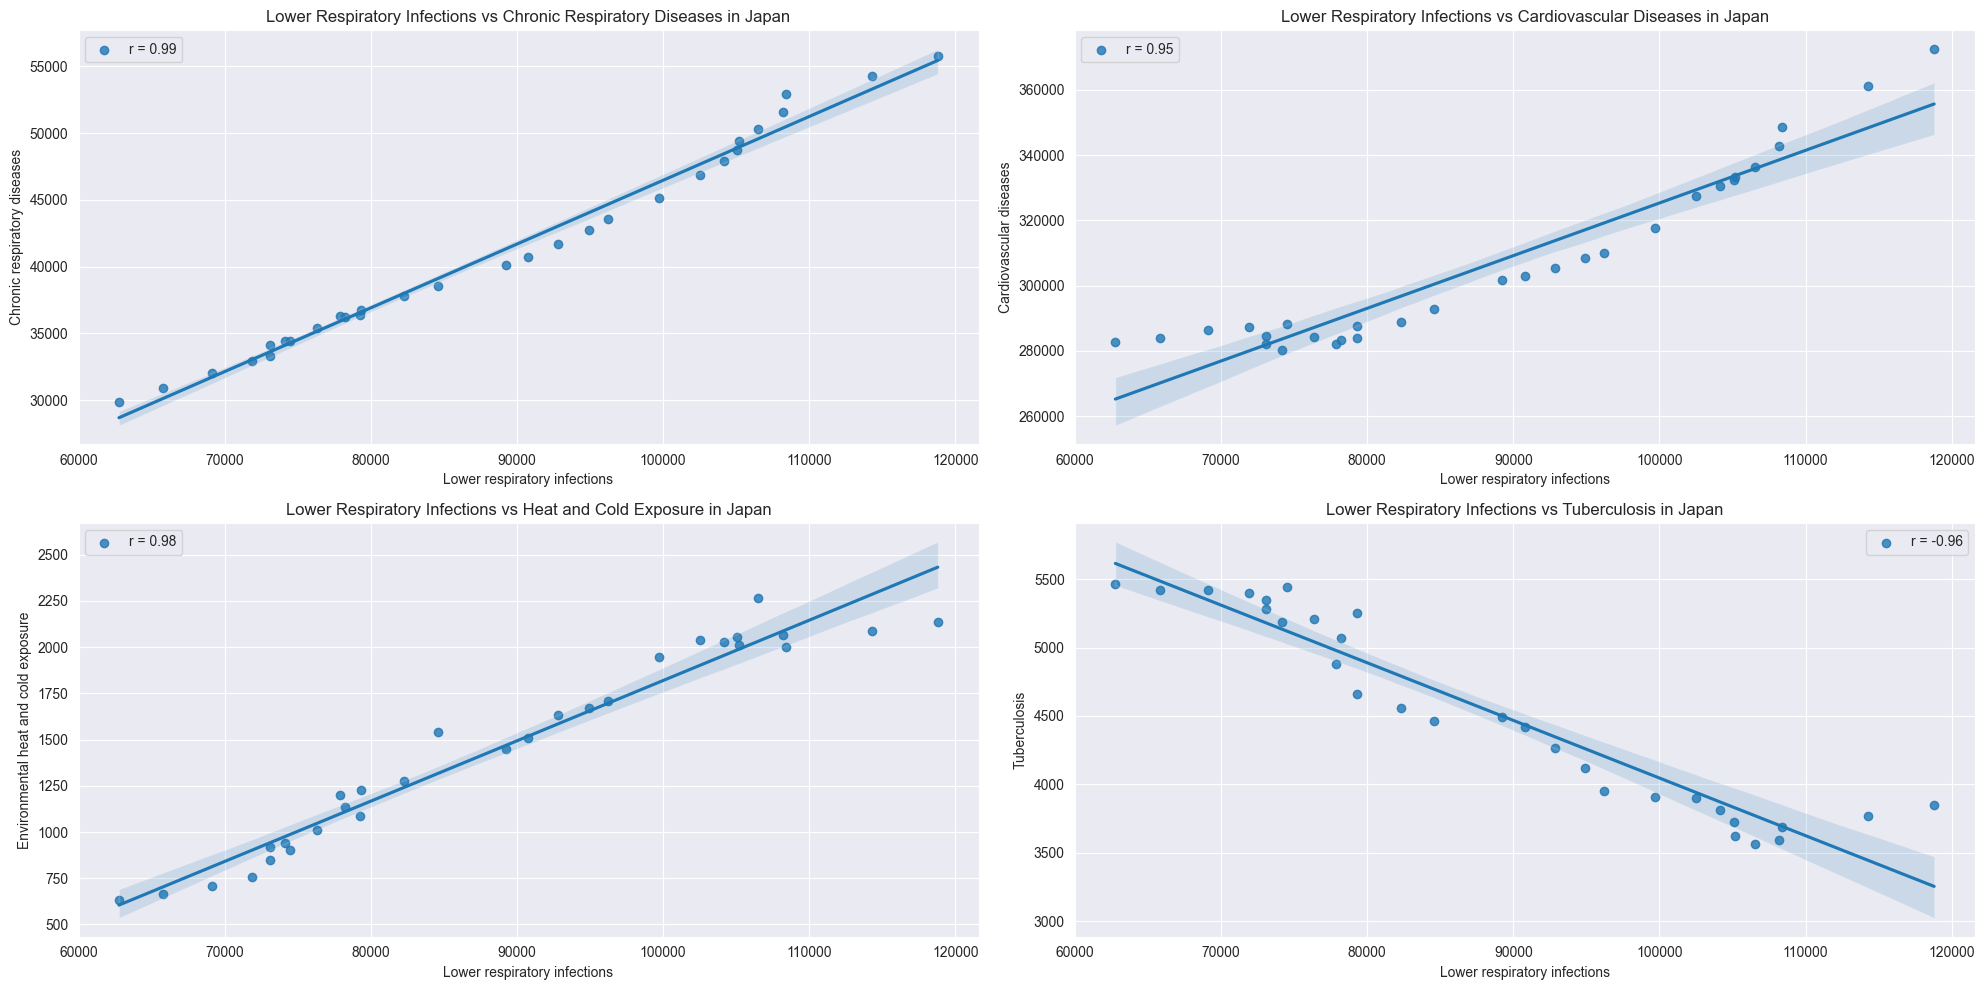

In [12]:
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize= (20, 10))

#correlation between lower respiratory infections and chronic respiratory diseases
corr_japan = df[df['Country'] == 'Japan'][['Country', 'Year', 'Lower respiratory infections','Chronic respiratory diseases']]
sns.regplot(data= corr_japan, x= 'Lower respiratory infections', y= 'Chronic respiratory diseases', ax=ax1)
r = corr_japan['Lower respiratory infections'].corr(corr_japan['Chronic respiratory diseases'])
ax1.legend(labels=[f'r = {r:.2f}'])
ax1.set_title('Lower Respiratory Infections vs Chronic Respiratory Diseases in Japan')

#correlation between lower respiratory infections and cardiovascular diseases
corr_japan = df[df['Country'] == 'Japan'][['Country', 'Year', 'Lower respiratory infections','Cardiovascular diseases']]
sns.regplot(data= corr_japan, x= 'Lower respiratory infections', y= 'Cardiovascular diseases' ,ax=ax2)
r = corr_japan['Lower respiratory infections'].corr(corr_japan['Cardiovascular diseases'])
ax2.legend(labels=[f'r = {r:.2f}'])
ax2.set_title('Lower Respiratory Infections vs Cardiovascular Diseases in Japan')

#correlation between lower respiratory infections and heat and cold exposure
corr_japan = df[df['Country'] == 'Japan'][['Country', 'Year', 'Lower respiratory infections','Environmental heat and cold exposure']]
sns.regplot(data= corr_japan, x= 'Lower respiratory infections', y= 'Environmental heat and cold exposure', ax=ax3)
r = corr_japan['Lower respiratory infections'].corr(corr_japan['Environmental heat and cold exposure'])
ax3.legend(labels=[f'r = {r:.2f}'])
ax3.set_title('Lower Respiratory Infections vs Heat and Cold Exposure in Japan')

#correlation between lower respiratory infections and tuberculosis
corr_japan = df[df['Country'] == 'Japan'][['Country', 'Year', 'Lower respiratory infections','Tuberculosis']]
sns.regplot(data= corr_japan, x= 'Lower respiratory infections', y= 'Tuberculosis', ax=ax4)
r = corr_japan['Lower respiratory infections'].corr(corr_japan['Tuberculosis'])
ax4.legend(labels=[f'r = {r:.2f}'])
ax4.set_title('Lower Respiratory Infections vs Tuberculosis in Japan')

plt.tight_layout()
plt.draw()
plt.savefig('graphs/correlation_in_japan.png')


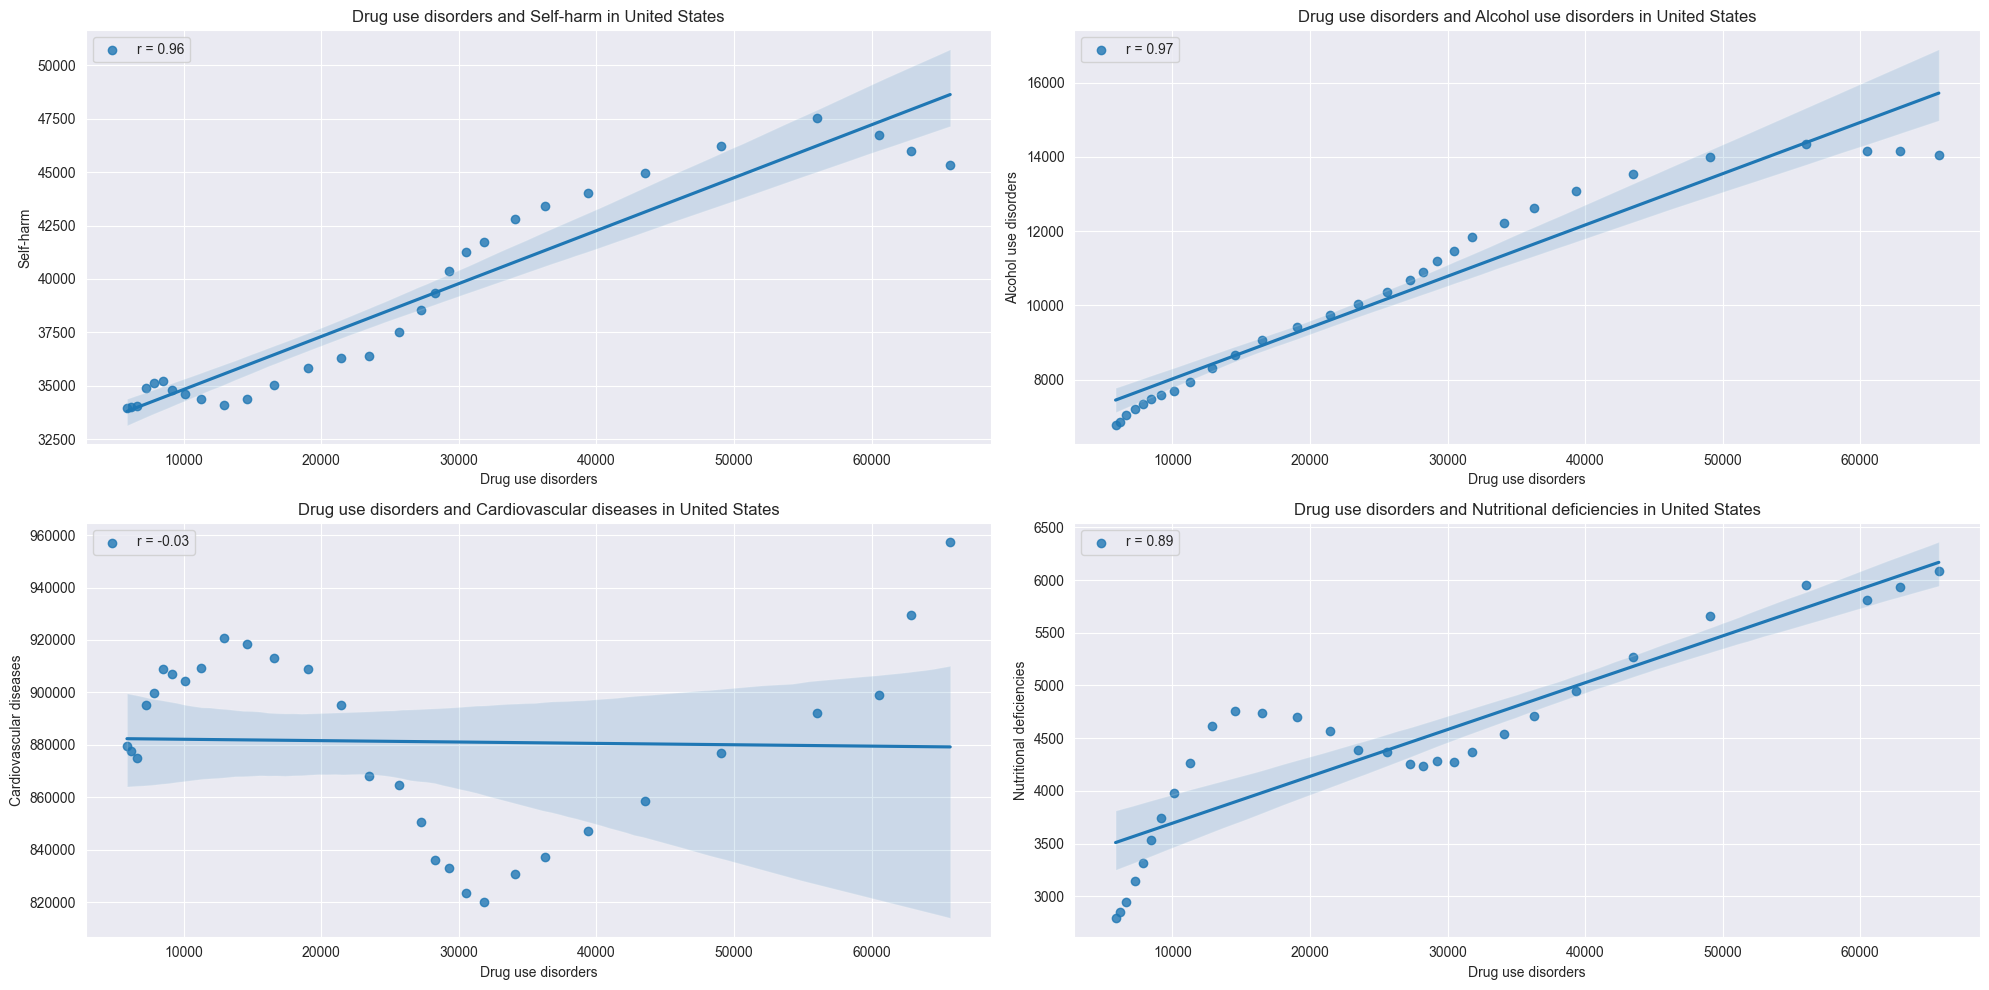

In [13]:
fig3, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize= (20, 10))
# correlation between drug use disorders and interpersonal violence in United States
corr_usa = df[df['Country'] == 'United States'][['Country', 'Year', 'Drug use disorders', 'Self-harm']]
sns.regplot(data=corr_usa, x='Drug use disorders', y='Self-harm',ax=ax1)
ax1.set_title('Drug use disorders and Self-harm in United States')
r = corr_usa['Drug use disorders'].corr(corr_usa['Self-harm'])
ax1.legend(labels=[f'r = {r:.2f}'])


# correlation between self-harm and interpersonal violence in United States
corr_usa = df[df['Country'] == 'United States'][['Drug use disorders', 'Alcohol use disorders']]
sns.regplot(data=corr_usa, x='Drug use disorders', y= 'Alcohol use disorders', ax=ax2)
ax2.set_title('Drug use disorders and Alcohol use disorders in United States')
r = corr_usa['Drug use disorders'].corr(corr_usa['Alcohol use disorders'])
ax2.legend(labels=[f'r = {r:.2f}'])

# correlation between self-harm and interpersonal violence in United States
corr_usa = df[df['Country'] == 'United States'][['Drug use disorders', 'Cardiovascular diseases']]
sns.regplot(data=corr_usa, x='Drug use disorders', y='Cardiovascular diseases', ax=ax3)
ax3.set_title('Drug use disorders and Cardiovascular diseases in United States')
r = corr_usa['Drug use disorders'].corr(corr_usa['Cardiovascular diseases'])
ax3.legend(labels=[f'r = {r:.2f}'])

# correlation between self-harm and conflict and terrorism in United States
corr_usa = df[df['Country'] == 'United States'][['Drug use disorders', 'Nutritional deficiencies']]
sns.regplot(data=corr_usa, x='Drug use disorders', y='Nutritional deficiencies', ax=ax4)
ax4.set_title('Drug use disorders and Nutritional deficiencies in United States')
r = corr_usa['Drug use disorders'].corr(corr_usa['Nutritional deficiencies'])
ax4.legend(labels=[f'r = {r:.2f}'])

fig.suptitle('Drug Use Disorder Correlation in United States', fontsize= 18)
plt.tight_layout()
plt.draw()
plt.savefig('graphs/correlation_in_united_states.png')


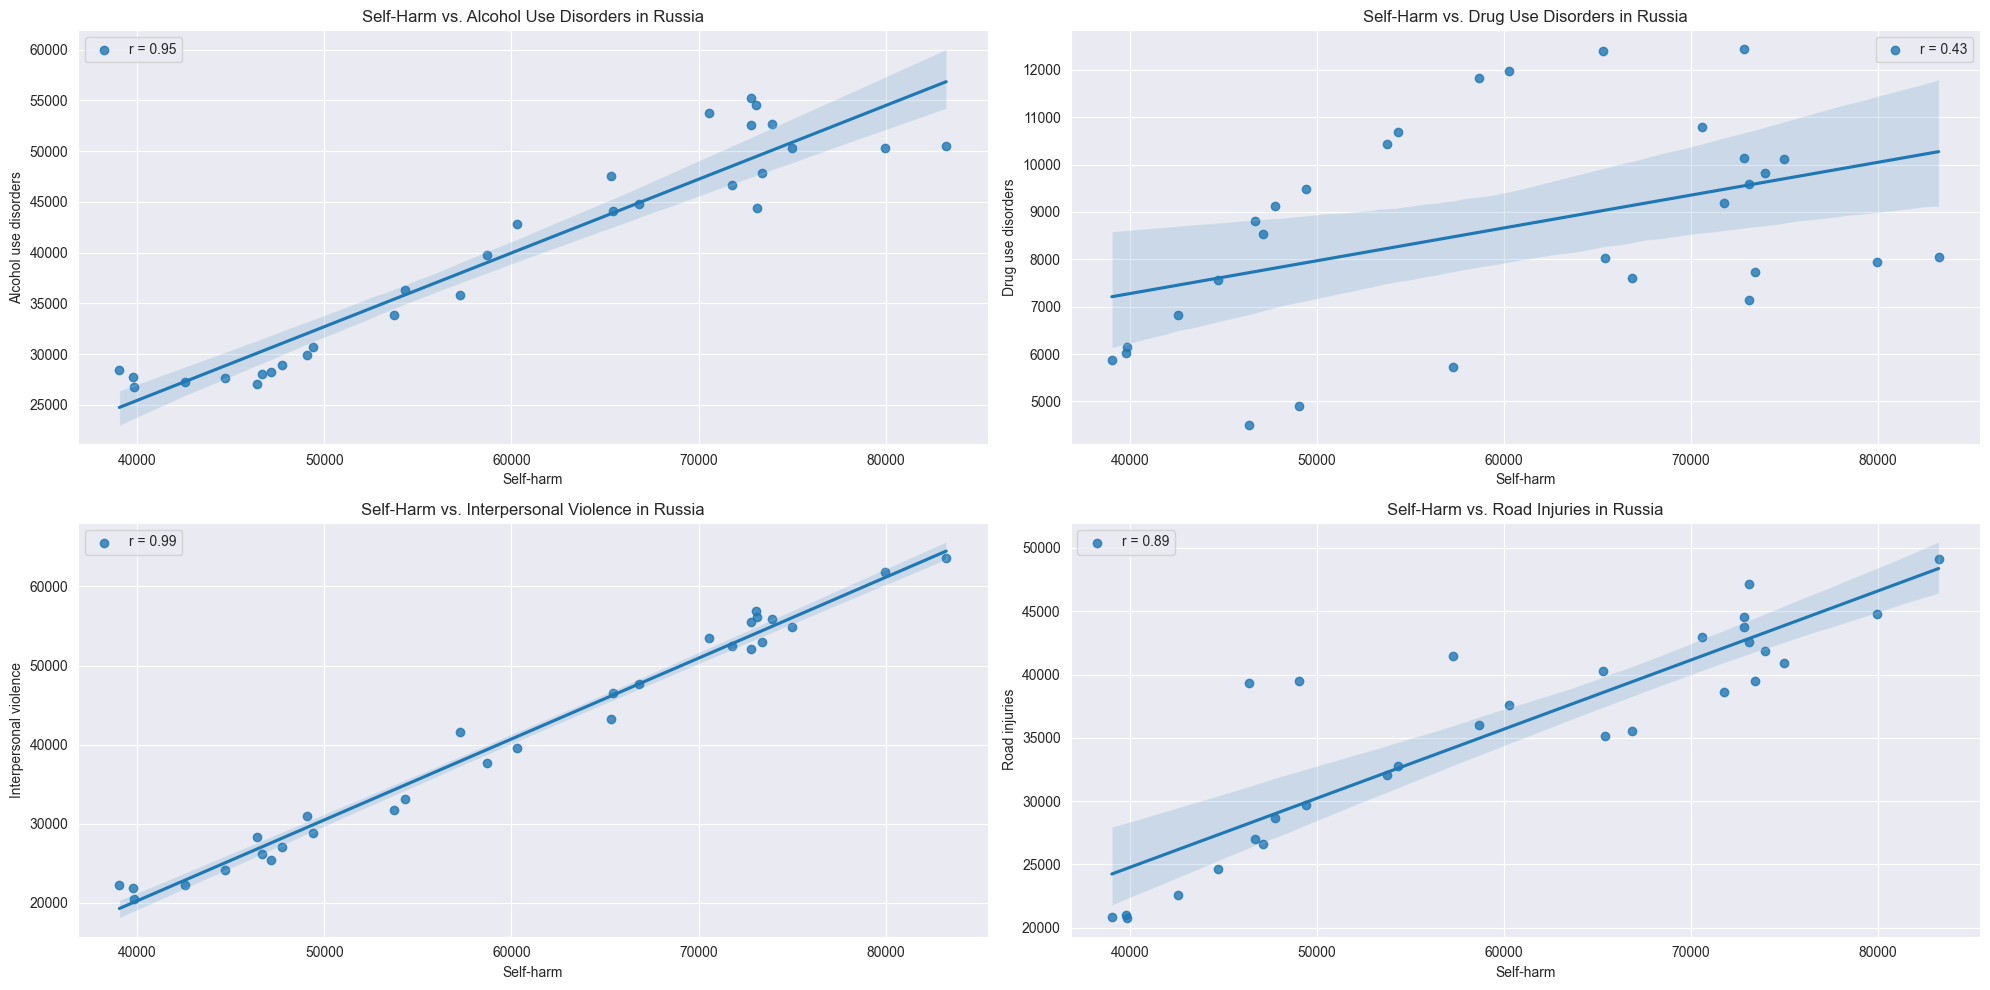

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize= (20, 10))
# correlation between self-harm and alcohol use disorders in Russia
corr_russia = df[df['Country'] == 'Russia'][['Country', 'Year', 'Self-harm','Alcohol use disorders']]
sns.regplot(data= corr_russia, x= 'Self-harm', y= 'Alcohol use disorders',ax=ax1)
r = corr_russia['Self-harm'].corr(corr_russia['Alcohol use disorders'])
ax1.legend(labels=[f'r = {r:.2f}'])
ax1.set_title('Self-Harm vs. Alcohol Use Disorders in Russia')
# correlation between self-harm and drug use disorders in Russia
corr_russia = df[df['Country'] == 'Russia'][['Country', 'Year', 'Self-harm','Drug use disorders']]
sns.regplot(data= corr_russia, x= 'Self-harm', y= 'Drug use disorders',ax=ax2)
r = corr_russia['Self-harm'].corr(corr_russia['Drug use disorders'])
ax2.legend(labels=[f'r = {r:.2f}'])
ax2.set_title('Self-Harm vs. Drug Use Disorders in Russia')
# correlation between self-harm and interpersonal violence in Russia
corr_russia = df[df['Country'] == 'Russia'][['Country', 'Year', 'Self-harm','Interpersonal violence']]
sns.regplot(data= corr_russia, x= 'Self-harm', y= 'Interpersonal violence',ax=ax3)
r = corr_russia['Self-harm'].corr(corr_russia['Interpersonal violence'])
ax3.legend(labels=[f'r = {r:.2f}'])
ax3.set_title('Self-Harm vs. Interpersonal Violence in Russia')
# correlation between self-harm and road injuries in Russia
corr_russia = df[df['Country'] == 'Russia'][['Country', 'Year', 'Self-harm','Road injuries']]
sns.regplot(data= corr_russia, x= 'Self-harm', y= 'Road injuries',ax=ax4)
r = corr_russia['Self-harm'].corr(corr_russia['Road injuries'])
ax4.legend(labels=[f'r = {r:.2f}'])
ax4.set_title('Self-Harm vs. Road Injuries in Russia')

plt.tight_layout()
plt.draw()
plt.savefig('graphs/correlation_in_russia.png')

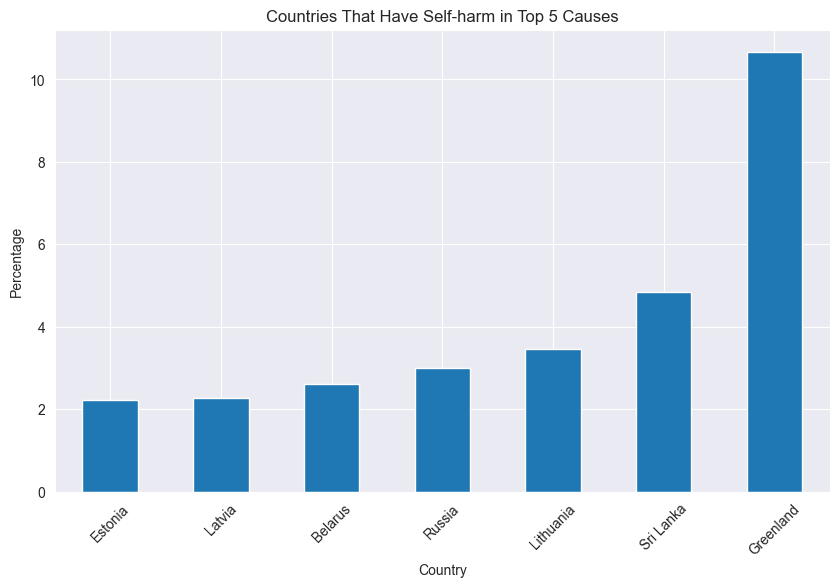

In [15]:
#setting up data for  countries where self-harm in top 5 causes of death
df2_largest = df2_percentage.apply(lambda x: x.nlargest(6), axis=1)
#calculating the percentage of self-harm top 5 countries
df2_harm_filtered = df2_largest[df2_largest.apply(lambda x: 'Self-harm' in x.index and not pd.isna(x['Self-harm']), axis=1)]

#removing eastern europe since it is not a country
countries = df2_harm_filtered.index
countries = countries[countries != 'Eastern Europe']
df2_harm_filtered = df2_harm_filtered[df2_harm_filtered.index.isin(countries)]
#plotting
df2_harm_filtered['Self-harm'].sort_values(ascending=True).plot(kind='bar', figsize=(10, 6), title='Countries That Have Self-harm in Top 5 Causes', rot=45, ylabel='Percentage')
plt.draw()
plt.savefig('graphs/self_harm_percentage.png')

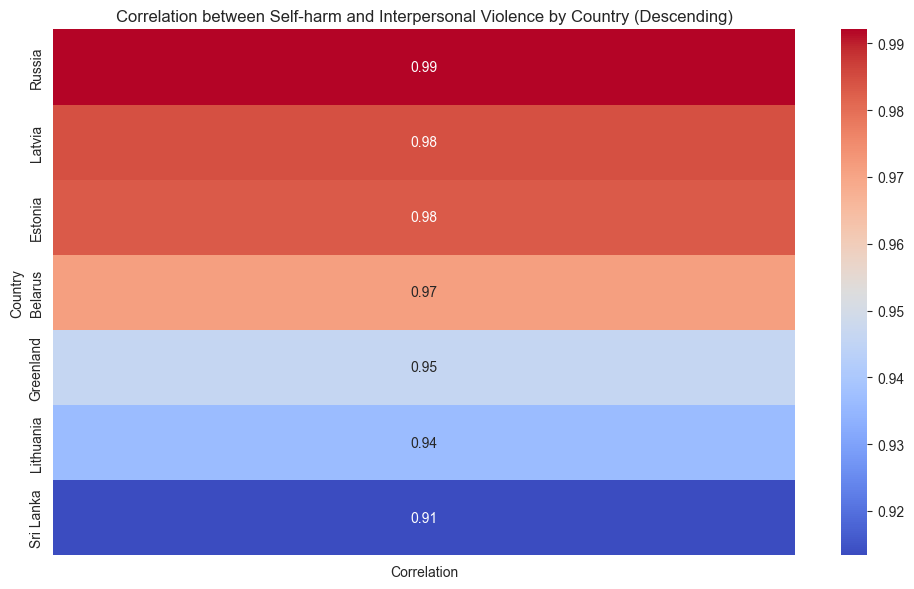

In [16]:
#correlation between self-harm and interpersonal violence in countries where self-harm in top 5 causes of death
df2_harm = df2[df2['Country'].isin(countries)]
correlations = {}

for country in countries:
    country_data = df2[df2['Country'] == country][['Self-harm', 'Interpersonal violence']]

    corr_value = country_data.corr().loc['Self-harm', 'Interpersonal violence']
    correlations[country] = corr_value

corr_df = pd.DataFrame(list(correlations.items()), columns=['Country', 'Correlation'])
corr_df.set_index('Country', inplace=True)

corr_df = corr_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation between Self-harm and Interpersonal Violence by Country (Descending)')

plt.tight_layout()
plt.draw()
plt.savefig('graphs/correlation_heatmap.png')

In [17]:
#checking eastern european countries
ee_countries = [
    "Russia", "Ukraine", "Belarus", "Estonia", "Latvia", "Lithuania", 
    "Poland", "Czech Republic", "Slovakia", "Hungary", "Romania", 
    "Bulgaria", "Moldova", "Albania", "Bosnia and Herzegovina", 
    "Croatia", "Kosovo", "Montenegro", "North Macedonia", "Serbia", 
    "Slovenia", 'Greece'
]
df_ee =  df2[df2['Country'].isin(ee_countries)].copy()
df_ee['Total Deaths'] = df_ee[causes].sum(axis=1)

df_ee_percentage = (df_ee[causes].div(df_ee['Total Deaths'], axis=0) * 100).round(2)

df_ee_percentage[['Country', 'Year']] = df_ee[['Country', 'Year']]
df_ee_percentage_grouped = df_ee_percentage.groupby('Country')[causes].mean().round(2)


ee_causes = []
threshold = 0.50

for column in df_ee_percentage_grouped.columns:
    if not df_ee_percentage_grouped[column].mean() <= threshold:
        ee_causes.append(column)
    
df_ee_percentage_grouped = df_ee_percentage_grouped[ee_causes]


alcohol_columns = ['Interpersonal violence', 'Road injuries', 'Alcohol use disorders', 'Self-harm', 'Cirrhosis and other chronic liver diseases']
ee_cumulative_mean = df_ee_percentage_grouped[alcohol_columns].mean().round(2)


alcohol_without_ee = df2.loc[~df2['Country'].isin(ee_countries)].groupby('Country')[alcohol_columns + ['Total Deaths']].mean().round(2).reset_index()


In [18]:
#for comparison, median is decided since it is more accurate
ee_alcohol_percentage = df_ee_percentage_grouped[alcohol_columns].sum(axis=1).median()

df2_percentage_without_ee = df2_percentage.loc[~df2_percentage.index.isin(ee_countries)]

world_alcohol_percentage = df2_percentage[alcohol_columns].sum(axis=1).median()
diff_alcohol_percentage = ee_alcohol_percentage - world_alcohol_percentage

russia_alcohol_percentage = df_ee_percentage_grouped.loc['Russia', alcohol_columns].sum().mean()

print(f'Alcohol related death percentage in Russia: {russia_alcohol_percentage:.2f}%')
print(f'Difference in alcohol related causes of death between Eastern Europe and World: {diff_alcohol_percentage:.2f}%')


Alcohol related death percentage in Russia: 10.81%
Difference in alcohol related causes of death between Eastern Europe and World: 0.31%


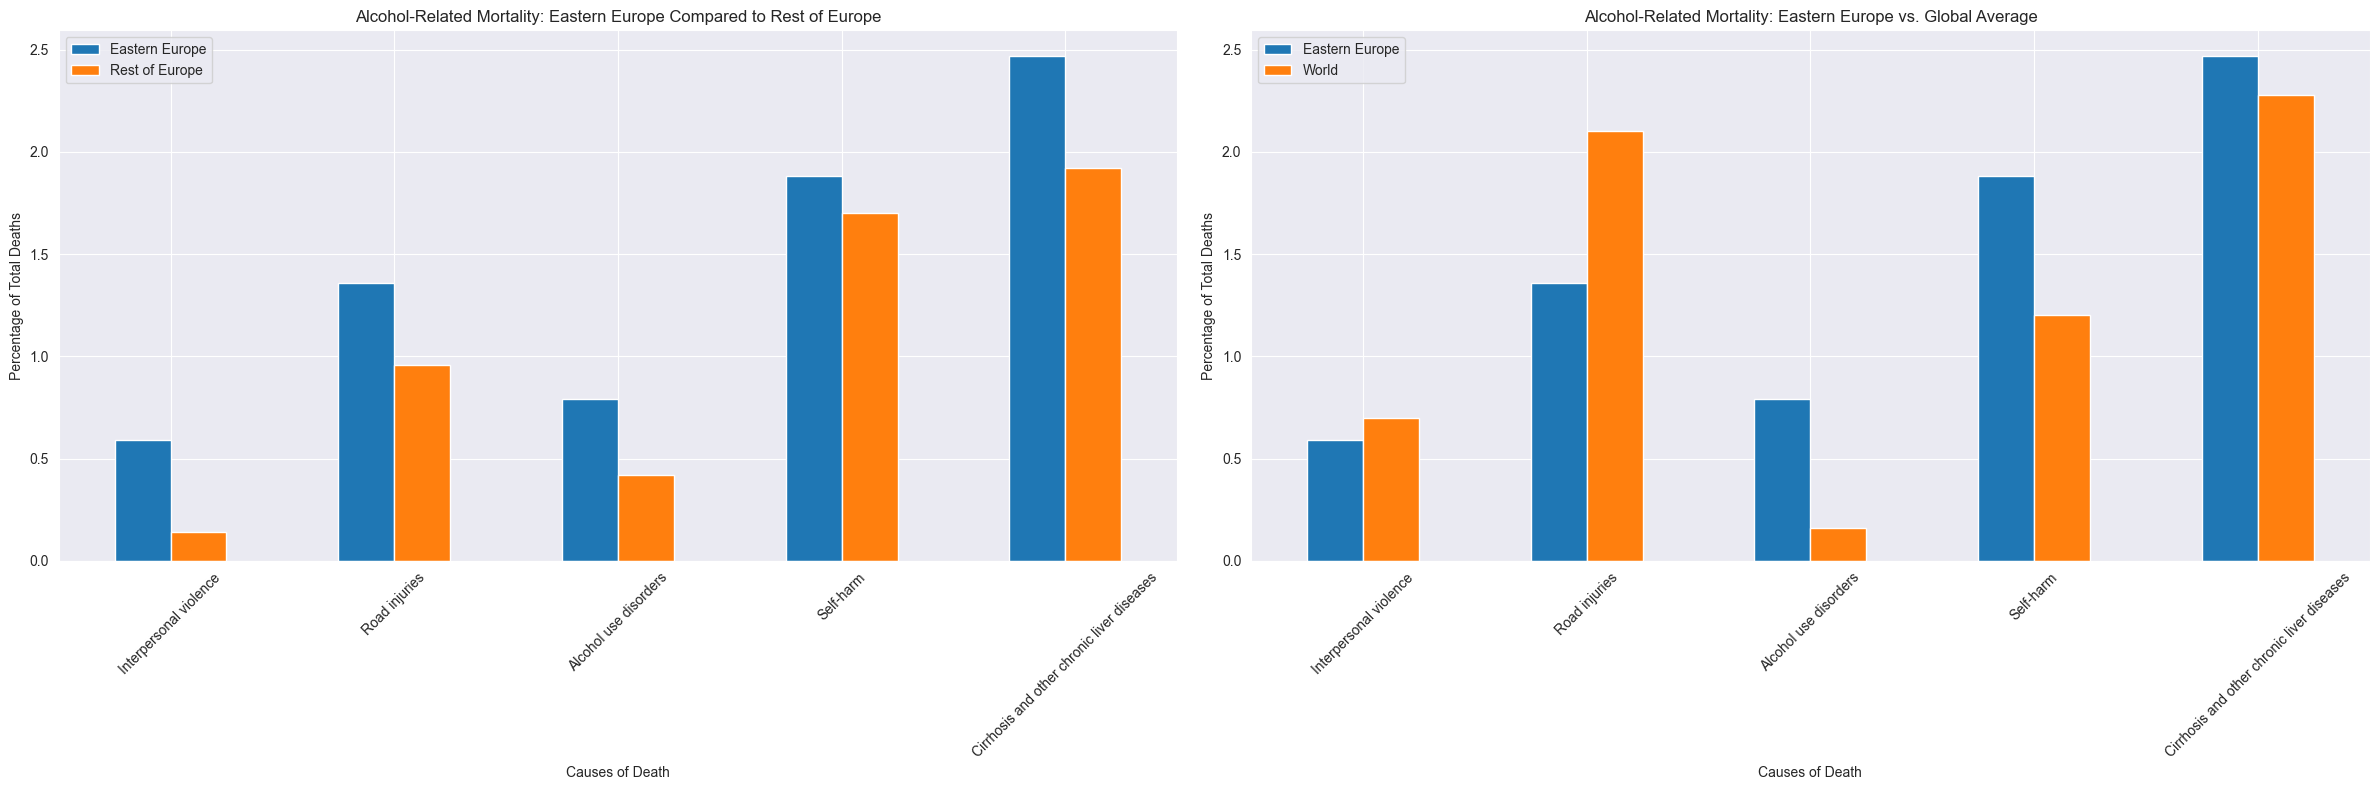

In [19]:
#comparing eastern europe with countries that have alcohol in their culture
europe_without_ee = ['Iceland', 'Norway', 'Switzerland', 'Sweden', 'United Kingdom', 'Portugal', 'Germany', 'Netherlands', 'Spain', 'France', 'Italy', 'Belgium', 'Finland', 'Ireland', 'Greece', 'Austria', 'Denmark']

alcohol_regions = alcohol_without_ee.reset_index()[alcohol_without_ee['Country'].isin(europe_without_ee)].groupby('Country')[alcohol_columns + ['Total Deaths']].median().round(2)
alcohol_comp_percentage = (alcohol_regions[alcohol_columns].div(alcohol_regions['Total Deaths'], axis=0) * 100).round(2)
region_cumulative_median = alcohol_comp_percentage.median().round(2)


#combining 
combined_median_diff = pd.concat([ee_cumulative_mean, region_cumulative_median], axis=1)
combined_median_diff.columns = ['Eastern Europe', 'Rest of Europe']


#adding whole world without ee
alcohol_world = alcohol_without_ee.groupby('Country')[alcohol_columns + ['Total Deaths']].median().round(2)
alcohol_world_percentage = (alcohol_world[alcohol_columns].div(alcohol_world['Total Deaths'], axis=0) * 100).round(2)
world_cumulative_median = alcohol_world_percentage.median().round(2)


#combining 
combined_median_diff_world = pd.concat([ee_cumulative_mean, world_cumulative_median], axis=1)
combined_median_diff_world.columns = ['Eastern Europe', 'World']


#plotting the difference
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
combined_median_diff.plot(kind='bar', ax=ax1)
ax1.set_title('Alcohol-Related Mortality: Eastern Europe Compared to Rest of Europe')
ax1.set_ylabel('Percentage of Total Deaths')
ax1.set_xlabel('Causes of Death')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

combined_median_diff_world.plot(kind='bar', ax=ax2)
ax2.set_title('Alcohol-Related Mortality: Eastern Europe vs. Global Average')
ax2.set_ylabel('Percentage of Total Deaths')
ax2.set_xlabel('Causes of Death')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig('graphs/diff_alcohol.png')
#eastern europes alcohol use and its consequences is observed both in europe and world

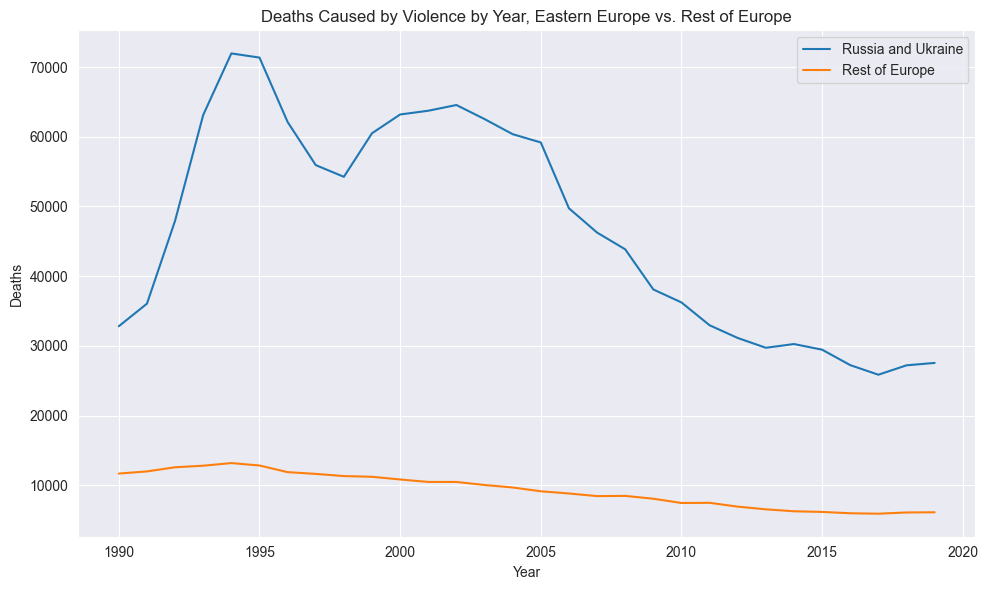

In [20]:
europe_without_ru_ua = [country for country in europe if country not in ['Russia', 'Ukraine']]
europe_violence_by_year = df2[df2['Country'].isin(europe_without_ru_ua)].groupby('Year')['Interpersonal violence'].sum()
russia_violence_by_year = df2[df2['Country'].isin(['Russia', 'Ukraine'])].groupby('Year')['Interpersonal violence'].sum()

violence_by_year = pd.concat([russia_violence_by_year, europe_violence_by_year], axis=1)
violence_by_year.columns = ['Russia and Ukraine', 'Rest of Europe']
violence_by_year.plot(kind = 'line', figsize=(10, 6))
plt.title('Deaths Caused by Violence by Year, Eastern Europe vs. Rest of Europe')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.tight_layout()
plt.savefig('graphs/violence_by_year.png')
#90-94 bosnian war, after 94 there is a downtrend

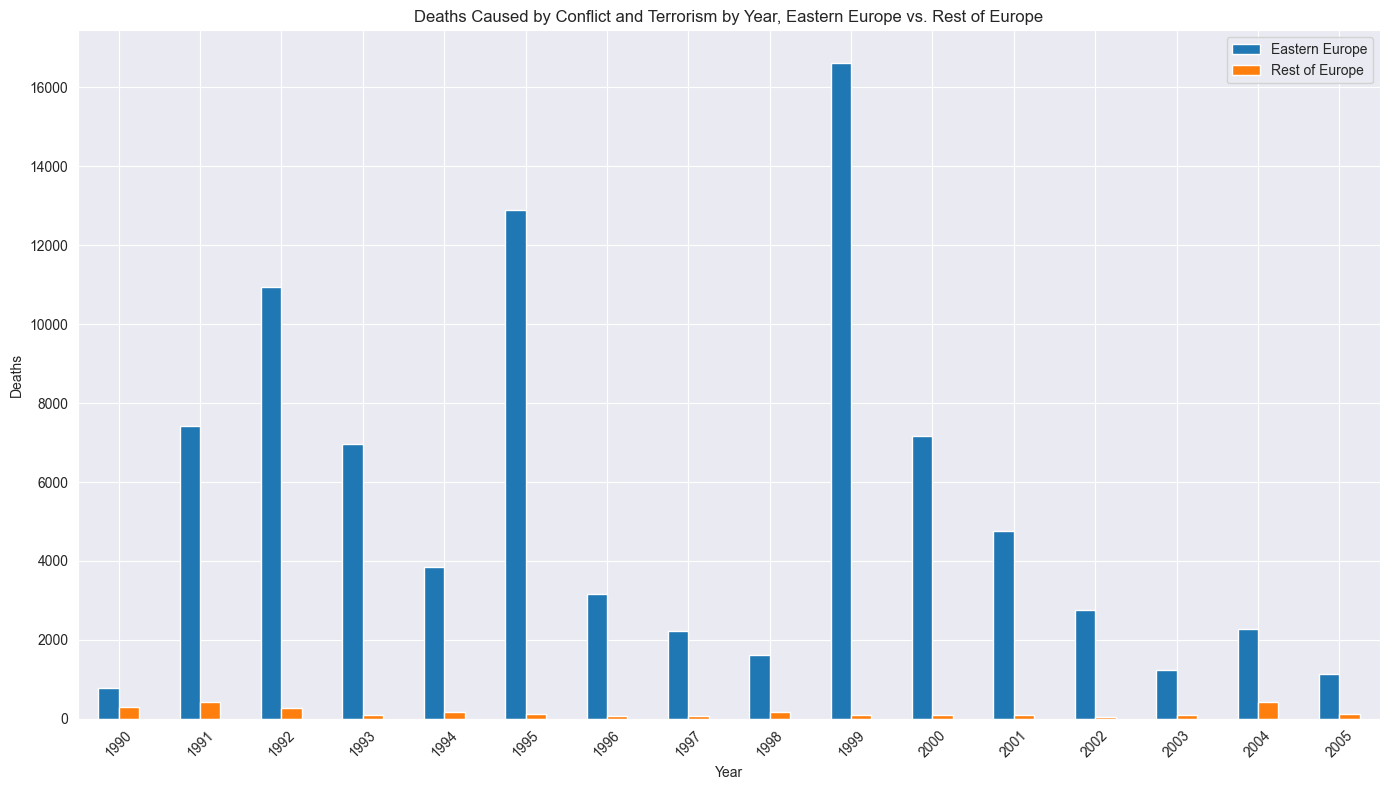

In [21]:
#eastern europes alcohol use and its consequences is observed both in europe and world
ee_conflict_by_year = df2[df2['Country'].isin(ee_countries)].groupby('Year')['Conflict and terrorism'].sum()
europe_conflict_by_year = df2[df2['Country'].isin(europe_without_ee)].groupby('Year')['Conflict and terrorism'].sum()

violence_by_year = pd.concat([ee_conflict_by_year, europe_conflict_by_year], axis=1)
violence_by_year.columns = ['Eastern Europe', 'Rest of Europe']
violence_by_year_filtered = violence_by_year.loc[(violence_by_year.index >= 1990) & (violence_by_year.index <= 2005)]

violence_by_year_filtered.plot(kind='bar', figsize=(14, 8))

plt.title('Deaths Caused by Conflict and Terrorism by Year, Eastern Europe vs. Rest of Europe')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.xticks(rotation= 45)
plt.tight_layout()

plt.draw()
plt.savefig('graphs/conflict.png')

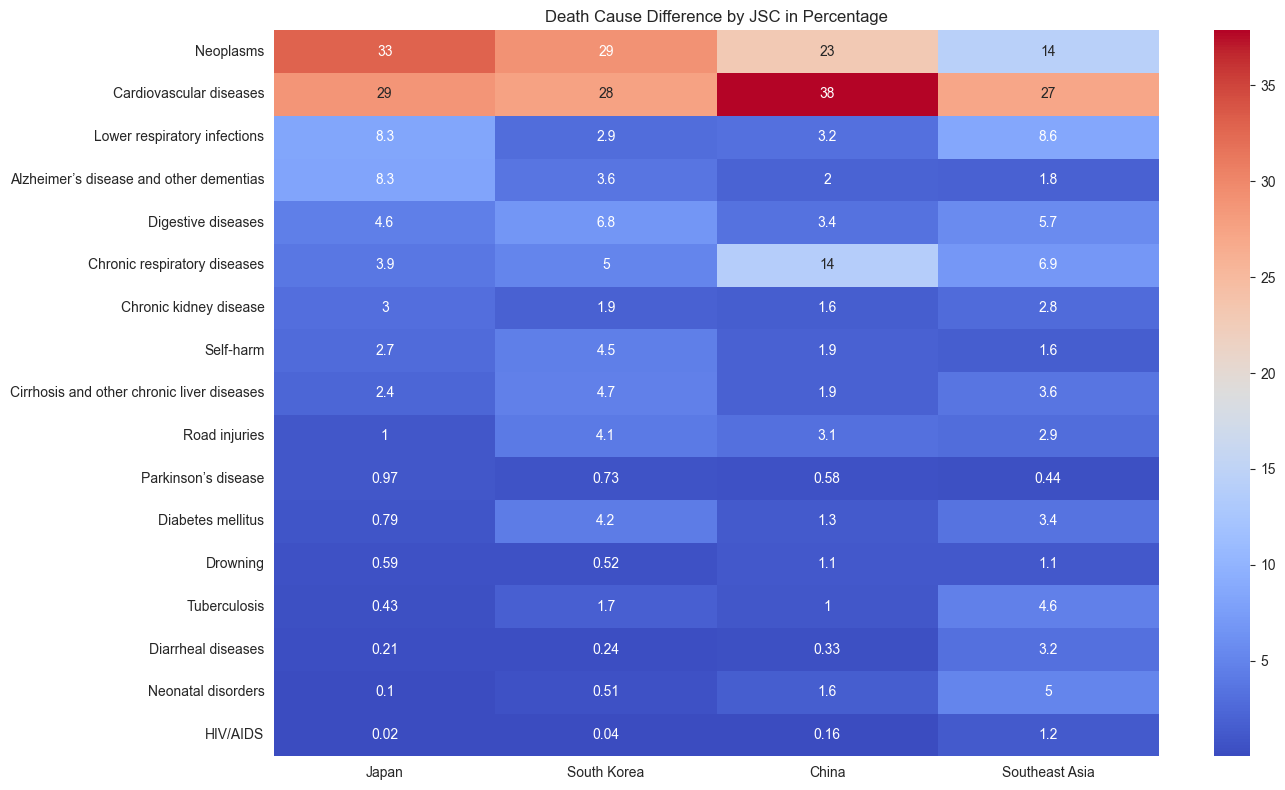

In [22]:
southeast_asia = asia_countries[3:]
asia_test = df2_percentage[df2_percentage.index.isin(southeast_asia)].mean()
asia_raw = pd.DataFrame(asia_test).T
asia_raw.index = ['Southeast Asia']

jsc_percentage = (df2_percentage[df2_percentage.index.isin(['Japan', 'South Korea', 'China'])]).round(2)
jsc_asia_concat = pd.concat([jsc_percentage, asia_raw], axis=0)
jsc = jsc_asia_concat.div(jsc_asia_concat['Total Deaths'], axis=0) *100
jsc = jsc.drop(['Total Deaths'], axis= 1)
jsc = jsc.apply(lambda x: x.nlargest(15), axis=1)
jsc = jsc.transpose().sort_values(by=['Japan', 'South Korea', 'China', 'Southeast Asia'], ascending=False)

jsc.loc['Cardiovascular diseases': , 'Japan'] = jsc_asia_concat.loc['Japan', jsc.index]
jsc.loc['Cardiovascular diseases': , 'South Korea'] = jsc_asia_concat.loc['South Korea', jsc.index]
jsc.loc['Cardiovascular diseases': , 'China'] = jsc_asia_concat.loc['China', jsc.index]
jsc.loc['Cardiovascular diseases': , 'Southeast Asia'] = jsc_asia_concat.loc['Southeast Asia', jsc.index]
jsc =jsc[['Japan', 'South Korea', 'China', 'Southeast Asia']]

plt.figure(figsize=(14, 8))
sns.heatmap(jsc, annot=True, cmap='coolwarm', cbar=True)
plt.title('Death Cause Difference by JSC in Percentage')
plt.tight_layout()
plt.draw()
plt.savefig('graphs/jsc_heatmap.png')

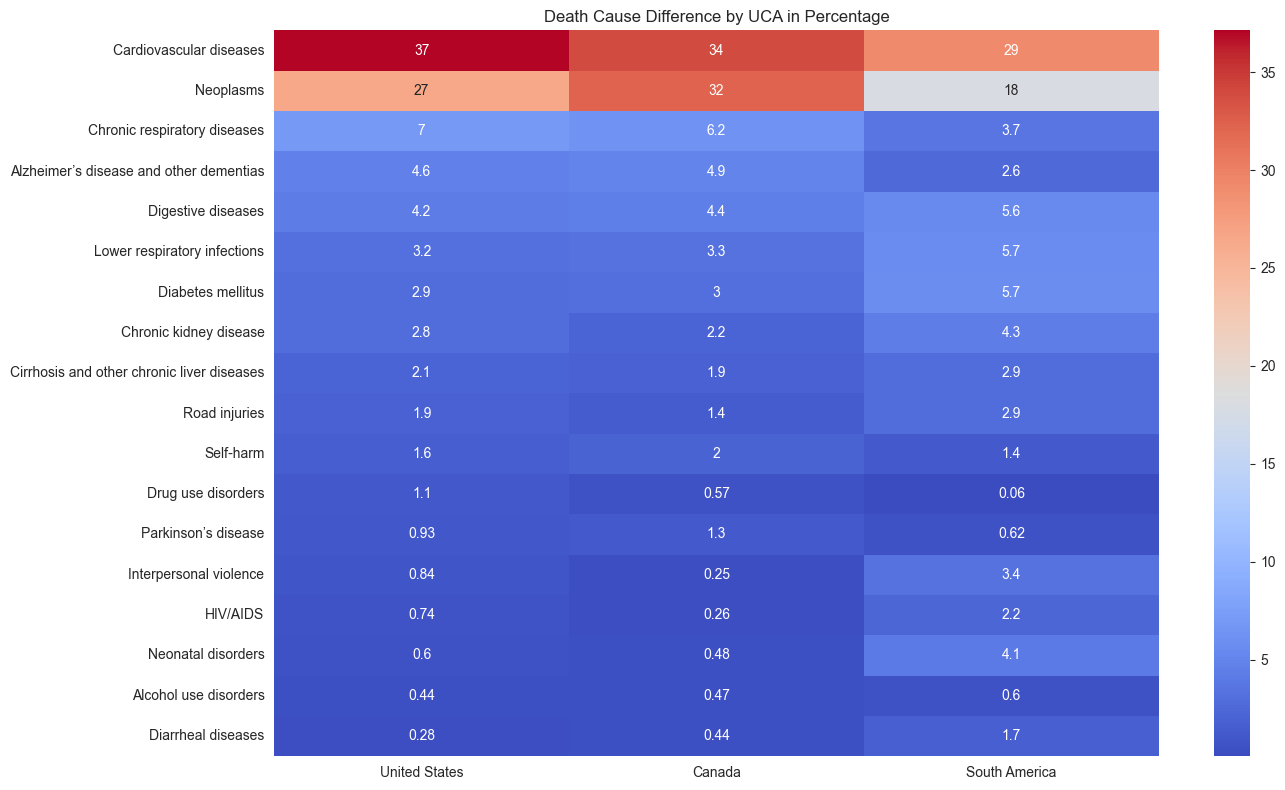

In [23]:
south_america = [
    'Argentina', 'Bahamas', 'Barbados', 'Belize', 'Bolivia', 'Brazil',
    'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 
    'Dominican Republic', 'Ecuador', 'El Salvador', 'Grenada', 'Guatemala', 
    'Guyana', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 
    'Panama', 'Paraguay', 'Peru', 'Saint Kitts and Nevis', 'Saint Lucia', 
    'Saint Vincent and the Grenadines', 'Suriname', 'Trinidad and Tobago', 
    'Uruguay', 'Venezuela'
]

america_test = df2_percentage[df2_percentage.index.isin(south_america)].mean()
america_raw = pd.DataFrame(america_test).T
america_raw.index = ['South America']
america_raw = (america_raw.drop(['Total Deaths'], axis=1))


america_percentage = (pd.concat([df2_percentage[df2_percentage.index.isin(['United States','Canada'])], america_raw], axis=0)).round(2)

uca = america_percentage.drop(['Total Deaths'], axis= 1)
uca = uca.apply(lambda x: x.nlargest(15), axis=1)
uca = uca.transpose().sort_values(by=['United States', 'Canada', 'South America'], ascending=False)


uca.loc['Cardiovascular diseases': , 'United States'] = america_percentage.loc['United States', uca.index]
uca.loc['Cardiovascular diseases': , 'Canada'] = america_percentage.loc['Canada', uca.index]
uca.loc['Cardiovascular diseases': , 'South America'] = america_percentage.loc['South America', uca.index]
uca = uca[['United States', 'Canada', 'South America']]

plt.figure(figsize=(14, 8))
sns.heatmap(uca, annot=True, cmap='coolwarm', cbar=True)
plt.title('Death Cause Difference by UCA in Percentage')
plt.tight_layout()
plt.draw()
plt.savefig('graphs/uca_heatmap.png')
